# Adding new features to improve Model
- Thêm biến tỉ lệ cá cược

In [1]:
import math 
import pandas as pd
import numpy as np
from collections import Counter

import scipy.stats as ss
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import seaborn as sns
from matplotlib import pyplot as plt

import sys
import os.path as path
lib_path =  path.abspath(path.join('' ,"../../api/common"))
sys.path.insert(1, lib_path)
from transform_split_data import transform_split_data
from predict import predict, evaluate

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

time: 125 ms


## 1. Load data
- Dữ liệu từ pre_process_data.csv

In [2]:
# Load dữ liệu
df = pd.read_csv('..\\pre_process_data\\pre_process_data.csv', encoding='utf-8')
data_df = df.copy()
data_df

,id$Year,id$MonthDay,id$JyoCD,id$Kaiji,id$Nichiji,id$RaceNum,race_id,Year,Month,RaceInfo$TokuNum,...,KS_SikakuCD,KS_MinaraiCD,KS_TozaiCD,KS_Syotai,KS_ChokyosiCode,CH_SexCD,CH_TozaiCD,CH_Syotai,top3,speed
0,2008,105,6,1,1,1,1,2008,1,0,...,2.0,0.0,1.0,,0.0,1,1,,0,57.446809
1,2008,105,6,1,1,1,1,2008,1,0,...,1.0,0.0,1.0,,0.0,1,1,,1,58.496953
2,2008,105,6,1,1,1,1,2008,1,0,...,2.0,0.0,1.0,,0.0,1,1,,1,58.221024
3,2008,105,6,1,1,1,1,2008,1,0,...,2.0,0.0,1.0,,0.0,1,1,,0,57.676903
4,2008,105,6,1,1,1,1,2008,1,0,...,2.0,0.0,1.0,,0.0,1,1,,1,58.457375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494336,2018,520,8,3,10,12,35925,2018,5,0,...,2.0,0.0,2.0,,0.0,1,2,,1,58.378378
494337,2018,520,8,3,10,12,35925,2018,5,0,...,2.0,0.0,2.0,,0.0,1,2,,0,57.857143
494338,2018,520,8,3,10,12,35925,2018,5,0,...,1.0,3.0,2.0,,1009.0,1,2,,0,57.754011
494339,2018,520,8,3,10,12,35925,2018,5,0,...,1.0,0.0,2.0,,411.0,1,2,,0,57.497782


time: 5.38 s


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494341 entries, 0 to 494340
Data columns (total 78 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id$Year                      494341 non-null  int64  
 1   id$MonthDay                  494341 non-null  int64  
 2   id$JyoCD                     494341 non-null  int64  
 3   id$Kaiji                     494341 non-null  int64  
 4   id$Nichiji                   494341 non-null  int64  
 5   id$RaceNum                   494341 non-null  int64  
 6   race_id                      494341 non-null  int64  
 7   Year                         494341 non-null  int64  
 8   Month                        494341 non-null  int64  
 9   RaceInfo$TokuNum             494341 non-null  int64  
 10  RaceInfo$Nkai                494341 non-null  int64  
 11  GradeCD                      494341 non-null  object 
 12  JyokenInfo$SyubetuCD         494341 non-null  int64  
 13 

## 2. Tạo thêm biến mới 

- Bổ sung biến Odds
    - Thêm biến tỉ lệ cược của trận trước
        - before_Odds

In [4]:
data_df['Odds'].describe()

count    494341.000000
mean        669.456754
std         956.082358
min          11.000000
25%          87.000000
50%         256.000000
75%         836.000000
max        9999.000000
Name: Odds, dtype: float64

time: 141 ms


In [5]:
data_df[['Odds', 'speed']].corr()

,Odds,speed
Odds,1.000000,-0.138943
speed,-0.138943,1.000000


time: 156 ms


In [6]:
new_data_df = data_df.sort_values(['KettoNum', 'race_id'], ascending=[True, True])
list_KettoNum = sorted(new_data_df['KettoNum'].unique())
list_before_Odds = np.array([])
for KettoNum in list_KettoNum:
    before_Odds = new_data_df[new_data_df['KettoNum']==KettoNum]['Odds'].shift(1)
    list_before_Odds = np.append(list_before_Odds, before_Odds)
  

time: 1min 41s


In [7]:
new_data_df['before_Odds'] = list_before_Odds
check = new_data_df.sort_values(['KettoNum', 'race_id'], ascending=[True, True])
check[['race_id', 'KettoNum', 'Odds','before_Odds']]

,race_id,KettoNum,Odds,before_Odds
2386,159,1997103860,986,NaN
4177,287,1997103860,85,986.0
7838,540,1997103860,673,85.0
9284,648,1997103860,779,673.0
13975,983,1997103860,304,779.0
...,...,...,...,...
480307,34903,2015110106,83,1317.0
484062,35171,2015110106,27,83.0
487130,35405,2015110106,153,27.0
487402,35425,2015110107,236,NaN


time: 562 ms


- Tính Odds trung bình cho những con ngựa mới

In [10]:
train_data = new_data_df[new_data_df['id$Year']<2018]
new_horse_df = train_data.loc[train_data['before_Odds'].isna(), :][['Odds', 'before_Odds']]
new_horse_mean = new_horse_df['Odds'].mean()
new_horse_mean

664.511213921255

time: 344 ms


In [11]:
new_data_df.loc[new_data_df['before_Odds'].isna(), 'before_Odds'] = new_horse_mean
new_data_df = new_data_df.sort_index()
new_data_df

,id$Year,id$MonthDay,id$JyoCD,id$Kaiji,id$Nichiji,id$RaceNum,race_id,Year,Month,RaceInfo$TokuNum,...,KS_MinaraiCD,KS_TozaiCD,KS_Syotai,KS_ChokyosiCode,CH_SexCD,CH_TozaiCD,CH_Syotai,top3,speed,before_Odds
0,2008,105,6,1,1,1,1,2008,1,0,...,0.0,1.0,,0.0,1,1,,0,57.446809,664.511214
1,2008,105,6,1,1,1,1,2008,1,0,...,0.0,1.0,,0.0,1,1,,1,58.496953,664.511214
2,2008,105,6,1,1,1,1,2008,1,0,...,0.0,1.0,,0.0,1,1,,1,58.221024,664.511214
3,2008,105,6,1,1,1,1,2008,1,0,...,0.0,1.0,,0.0,1,1,,0,57.676903,664.511214
4,2008,105,6,1,1,1,1,2008,1,0,...,0.0,1.0,,0.0,1,1,,1,58.457375,664.511214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494336,2018,520,8,3,10,12,35925,2018,5,0,...,0.0,2.0,,0.0,1,2,,1,58.378378,51.000000
494337,2018,520,8,3,10,12,35925,2018,5,0,...,0.0,2.0,,0.0,1,2,,0,57.857143,29.000000
494338,2018,520,8,3,10,12,35925,2018,5,0,...,3.0,2.0,,1009.0,1,2,,0,57.754011,1669.000000
494339,2018,520,8,3,10,12,35925,2018,5,0,...,0.0,2.0,,411.0,1,2,,0,57.497782,26.000000


time: 656 ms


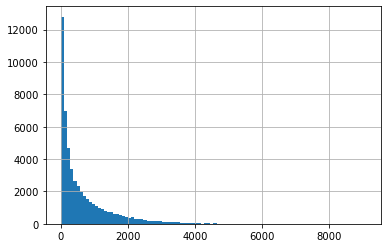

time: 484 ms


In [12]:
new_horse_df['Odds'].hist(bins=100);

In [ ]:
"""sns.set()
plot = sns.jointplot(x="Odds", y="speed", data=new_data_df,
                     height=7, ratio=5, 
                     kind='reg', joint_kws={'line_kws':{'color':'y'}},
                     #stat_func=stats.pearsonr,
                     );
plot.fig.suptitle('scatter chart of Odds and speed');
plot.fig.subplots_adjust(top=0.91);"""


## 3. Tạo dữ liệu mới 

- Load danh sách features đã được chọn tự động

In [13]:
import json
with open('..\\feature_selection\\feature_dict.json') as js:
    feature_dict = json.load(js)
feature_dict

{'selected_feature': ['Kyori',
  'TenkoBaba$DirtBabaCD',
  'TenkoBaba$SibaBabaCD',
  'id$RaceNum',
  'TrackCD',
  'JyokenInfo$SyubetuCD',
  'GradeCD',
  'Honsyokin',
  'KS_SikakuCD',
  'Futan',
  'JyokenInfo$KigoCD',
  'JyokenInfo$JyuryoCD',
  'SexCD',
  'id$JyoCD',
  'BaTaijyu',
  'Month',
  'KS_ChokyosiCode',
  'Umaban',
  'TozaiCD',
  'Barei',
  'HN_HansyokuMochiKubun',
  'MinaraiCD',
  'KS_TozaiCD',
  'UmaKigoCD',
  'TenkoBaba$TenkoCD',
  'id$Kaiji',
  'id$Nichiji',
  'ZogenSa',
  'CH_Syotai',
  'KeiroCD',
  'KS_Syotai',
  'Year',
  'KS_SexCD'],
 'extract_feature': ['Kyori',
  'TenkoBaba$DirtBabaCD_0',
  'TenkoBaba$SibaBabaCD_0',
  'TenkoBaba$SibaBabaCD_1',
  'TenkoBaba$DirtBabaCD_1',
  'id$RaceNum',
  'TrackCD_52',
  'TrackCD_17',
  'JyokenInfo$SyubetuCD_18',
  'GradeCD_ ',
  'GradeCD_E',
  'TrackCD_24',
  'JyokenInfo$SyubetuCD_19',
  'Honsyokin',
  'JyokenInfo$SyubetuCD_13',
  'TrackCD_10',
  'TrackCD_54',
  'TrackCD_11',
  'KS_SikakuCD_3.0',
  'Futan',
  'JyokenInfo$KigoCD_A00',

time: 156 ms


In [14]:
id_col = ['race_id', 'KettoNum', 'id$Year']
cat_col = feature_dict['cat_col']
num_col = feature_dict['num_col']
target_col = [
                'Time',
                'TimeDiff',
                'speed',
                'KakuteiJyuni',
                'top3'
             ]


time: 125 ms


- Bổ sung feature mới vào danh sách feature

In [15]:
new_col = ['before_Odds']
new_num_col = num_col + new_col
new_num_col

['id$Kaiji',
 'id$Nichiji',
 'id$RaceNum',
 'Year',
 'Kyori',
 'Honsyokin',
 'Fukasyokin',
 'Barei',
 'Futan',
 'BaTaijyu',
 'ZogenSa',
 'before_Odds']

time: 110 ms


- Create offer data

In [16]:
columns = id_col + cat_col + new_num_col + target_col
offer_data = new_data_df[columns]
offer_data

,race_id,KettoNum,id$Year,Month,id$JyoCD,GradeCD,JyokenInfo$SyubetuCD,JyokenInfo$KigoCD,JyokenInfo$JyuryoCD,TrackCD,...,Barei,Futan,BaTaijyu,ZogenSa,before_Odds,Time,TimeDiff,speed,KakuteiJyuni,top3
0,1,2005107051,2008,1,6,,12,023,3,24,...,3,540,428.0,12,664.511214,75.20,13,57.446809,8,0
1,1,2005102028,2008,1,6,,12,023,3,24,...,3,540,450.0,-10,664.511214,73.85,0,58.496953,1,1
2,1,2005104156,2008,1,6,,12,023,3,24,...,3,540,458.0,4,664.511214,74.20,3,58.221024,3,1
3,1,2005105319,2008,1,6,,12,023,3,24,...,3,540,402.0,-10,664.511214,74.90,10,57.676903,6,0
4,1,2005101044,2008,1,6,,12,023,3,24,...,3,540,482.0,2,664.511214,73.90,0,58.457375,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494336,35925,2014105425,2018,5,8,,14,A03,4,24,...,4,570,478.0,0,51.000000,111.00,-9,58.378378,1,1
494337,35925,2014105543,2018,5,8,,14,A03,4,24,...,4,570,504.0,2,29.000000,112.00,10,57.857143,5,0
494338,35925,2011106130,2018,5,8,,14,A03,4,24,...,7,540,484.0,0,1669.000000,112.20,12,57.754011,6,0
494339,35925,2012102418,2018,5,8,,14,A03,4,24,...,6,570,504.0,2,26.000000,112.70,17,57.497782,8,0


time: 406 ms


- Transform and split data

In [17]:
X_train, y_train_df, X_test, y_test_df, id_train, id_test, _, _ = transform_split_data(offer_data, id_col, cat_col, new_num_col, scale_data=True, target='speed', drop=None,
                                                                                                                                                          shuffle=True, ref_col=None)
X_train

,Month_1,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,...,id$RaceNum,Year,Kyori,Honsyokin,Fukasyokin,Barei,Futan,BaTaijyu,ZogenSa,before_Odds
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.381357,-1.215425,-0.560469,-0.300505,-0.530331,-0.462495,-0.590940,-0.605004,-0.042886,-0.709237
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.965836,1.220895,-1.045283,-0.547701,-0.530331,-0.462495,-0.590940,-1.408039,-0.042886,0.072652
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.495360,-0.519334,0.409159,-0.209043,-0.530331,0.304849,0.554797,-0.538085,0.570235,-0.524838
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.089118,-0.867379,-0.075655,-0.300505,-0.530331,-1.229838,-0.590940,-0.002729,-0.042886,0.072652
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.495360,1.220895,-1.045283,-0.300505,-0.530331,0.304849,-0.018072,-0.136568,1.183356,-0.654645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475191,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.495360,1.568941,0.409159,-0.195447,-0.530331,1.072192,-0.018072,1.469500,1.489917,-0.058988
475192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.079838,0.524803,0.409159,1.513911,2.032646,2.606879,-0.018072,2.138695,0.876796,0.570637
475193,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.787599,1.568941,1.378788,1.578182,1.895344,1.839535,-0.590940,0.198030,0.570235,-0.597627
475194,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.372077,1.568941,-1.530097,2.322241,1.758042,1.072192,1.127665,0.867225,1.489917,-0.567298


time: 19.5 s


- Update dữ liệu mới vào dữ liệu đã chọn feature tự động

In [19]:
extract_feature = feature_dict['extract_feature']
new_extract_feature = extract_feature + new_col
X_train = X_train[new_extract_feature]
X_test = X_test[new_extract_feature]
X_train

,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,TrackCD_17,JyokenInfo$SyubetuCD_18,GradeCD_,...,CH_Syotai_岩手,KS_Syotai_アメリカ,CH_Syotai_荒尾,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,before_Odds
0,-0.560469,0.0,1.0,0.0,1.0,-0.381357,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.709237
1,-1.045283,0.0,1.0,0.0,1.0,-0.965836,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072652
2,0.409159,0.0,1.0,0.0,1.0,0.495360,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.524838
3,-0.075655,1.0,0.0,1.0,0.0,-0.089118,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072652
4,-1.045283,1.0,0.0,1.0,0.0,0.495360,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.654645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475191,0.409159,0.0,1.0,0.0,0.0,0.495360,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.058988
475192,0.409159,0.0,1.0,0.0,0.0,1.079838,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.570637
475193,1.378788,1.0,0.0,1.0,0.0,0.787599,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.597627
475194,-1.530097,1.0,0.0,0.0,0.0,1.372077,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.567298


time: 468 ms


In [20]:
y_train = y_train_df['speed']
y_train.describe()

count    475196.000000
mean         58.393319
std           2.308153
min          21.973550
25%          56.942004
50%          58.536585
75%          59.916782
max          66.666667
Name: speed, dtype: float64

time: 141 ms


In [21]:
y_test = y_test_df['speed']
y_test.describe()

count    19145.000000
mean        58.013408
std          2.305421
min         38.876890
25%         56.509695
50%         58.142665
75%         59.558824
max         65.573770
Name: speed, dtype: float64

time: 125 ms


## 4. Train với simple model 

In [22]:
from sklearn.linear_model import LinearRegression

def train_model(X_train, y_train, y_train_df): 
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    return lr_model


time: 125 ms


In [23]:
def evaluate(model, X, y_df):
    rate, r2, mae, rmse, result_df = predict(model, X, y_df)
    print('Sai số rmse:                    %.3f'%rmse)
    print('Hệ số xác định r2-score: %.3f'%r2)
    print('Tỉ lệ True positive:           %.3f'%rate)
    return result_df

time: 110 ms


- Train model

In [24]:
model = train_model(X_train, y_train, y_train_df)


time: 3.94 s


- Evaluate 

In [25]:
# On train 
train_result_df = evaluate(model, X_train, y_train_df)
#train_result_df

Sai số rmse:                    0.926
Hệ số xác định r2-score: 0.839
Tỉ lệ True positive:           0.364
time: 19.4 s


In [26]:
# On test
test_result_df = evaluate(model, X_test, y_test_df)
#test_result_df

Sai số rmse:                    0.953
Hệ số xác định r2-score: 0.829
Tỉ lệ True positive:           0.387
time: 187 ms


- <span style="color:blue">Nhận xét:
    - Độ chính xác mô hình được cải thiện rõ rệt
   

## 5. Lưu dữ liệu mới
- Dữ liệu và danh sách feature mới nhất

In [27]:
train_data = pd.concat([id_train, X_train], axis=1, sort=False)
train_data['speed'] = y_train_df['speed']
train_data

,race_id,KettoNum,id$Year,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,...,KS_Syotai_アメリカ,CH_Syotai_荒尾,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,before_Odds,speed
0,4739,2006102819,2009,-0.560469,0.0,1.0,0.0,1.0,-0.381357,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.709237,59.433962
1,27702,2013104745,2016,-1.045283,0.0,1.0,0.0,1.0,-0.965836,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072652,56.767411
2,10633,2007101765,2011,0.409159,0.0,1.0,0.0,1.0,0.495360,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.524838,56.470588
3,8902,2008100059,2010,-0.075655,1.0,0.0,1.0,0.0,-0.089118,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072652,58.655804
4,28225,2012104831,2016,-1.045283,1.0,0.0,1.0,0.0,0.495360,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.654645,63.576159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475191,31174,2012100286,2017,0.409159,0.0,1.0,0.0,0.0,0.495360,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.058988,55.574614
475192,23938,2007104998,2014,0.409159,0.0,1.0,0.0,0.0,1.079838,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.570637,56.792287
475193,32138,2011101513,2017,1.378788,1.0,0.0,1.0,0.0,0.787599,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.597627,59.459459
475194,32286,2012102017,2017,-1.530097,1.0,0.0,0.0,0.0,1.372077,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.567298,63.492063


time: 593 ms


In [28]:
test_data = pd.concat([id_test, X_test], axis=1, sort=False)
test_data['speed'] = y_test_df['speed']
test_data

,race_id,KettoNum,id$Year,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,...,KS_Syotai_アメリカ,CH_Syotai_荒尾,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,before_Odds,speed
0,34535,2015101022,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.638874,58.064516
1,34535,2015103483,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.068149,57.908847
2,34535,2015106010,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.547888,59.178082
3,34535,2015102342,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.188494,58.775510
4,34535,2015102323,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.456902,57.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19140,35925,2014105425,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.671629,58.378378
19141,35925,2014105543,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.698319,57.857143
19142,35925,2011106130,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.291248,57.754011
19143,35925,2012102418,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.701958,57.497782


time: 171 ms


In [29]:
y_train_df.to_csv('y_train_df_ip2.csv', index=False)

time: 2.31 s


In [30]:
y_test_df.to_csv('y_test_df_ip2.csv', index=False)

time: 203 ms


In [31]:
train_data.to_csv('train_data_ip2.csv', index=False)
test_data.to_csv('test_data_ip2.csv', index=False)

time: 1min 15s


- Update feature_dict and save

In [32]:
feature_dict['new_col'] = new_col

time: 125 ms


In [33]:
import json
with open('feature_dict_ip2.json', 'w') as js:
    json.dump(feature_dict, js)


time: 125 ms
